In [1]:
!nvidia-smi

Mon Apr 18 10:47:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:8B:00.0 Off |                  N/A |
| 46%   28C    P8     8W / 105W |   7645MiB /  8117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Inštalácia knižníc

In [2]:
!pip install opencv-python
!pip install keras
!pip install scikit-plot

     |████████████████████████████████| 60.5 MB 30.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 7.6 MB/s eta 0:00:01


### Import knižníc

In [3]:
from sys import stdout
from tensorflow import keras
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from csv import DictWriter

import tensorflow as tf
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle as pkl

### Zadefinovanie funkcie

In [20]:
#vykreslenie procesu učenia
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Načítanie snímok

In [22]:
# načítanie predspracovaných dát
with open('train.pkl','rb') as f: X_train, train_df = pkl.load(f)
with open('test.pkl','rb') as f: X_test, test_df = pkl.load(f)
with open('valid.pkl','rb') as f: X_valid, valid_df = pkl.load(f)

y_train = train_df["class"]
y_test = test_df["class"]
y_valid = valid_df["class"]

In [23]:
print("TrainSetInto: {}".format(X_train.shape))
print("TestSetInto: {}".format(X_test.shape))
print("ValidSetInto: {}".format(X_valid.shape))

TrainSetInto: (4668, 299, 299, 1)
TestSetInto: (1191, 299, 299, 1)
ValidSetInto: (100, 299, 299, 1)


<AxesSubplot:>

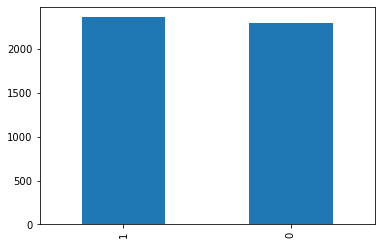

In [24]:
y_train.value_counts().plot.bar()

<AxesSubplot:>

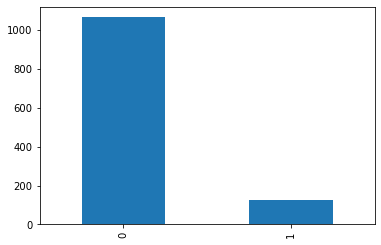

In [25]:
y_test.value_counts().plot.bar()

<AxesSubplot:>

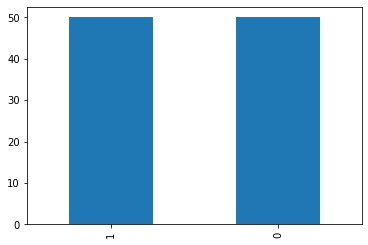

In [26]:
y_valid.value_counts().plot.bar()

### Architektúra siete

In [27]:
drop1 = 0.25 
drop2 = 0.5 
dense = 1024
epochs = 20
batch_size = 40 

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=[299, 299,1], activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(dense, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 295, 295, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 295, 295, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 147, 147, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 147, 147, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 145, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 143, 143, 64)      3

### Vytvorenie záchytných bodov

In [11]:
# ukladanie najlepšieho modelu podľa validačnej chyby
callback1 = ModelCheckpoint('../FrantisekUrban/callback_model/model2.hdf5',
                            monitor = 'val_loss', 
                            verbose = 1, 
                            save_best_only = True, 
                            mode = 'min')

In [12]:
# ukladanie váh modelu počas každej druhej epochy
STEPS_PER_EPOCH = y_train.size / batch_size
SAVE_PERIOD = 2

filepath = "../FrantisekUrban/callback_model/saved-model2-{epoch:02d}.h5"
checkpoint1 = ModelCheckpoint(filepath, verbose=1, save_best_only=False, save_weights_only=True, save_freq=int(SAVE_PERIOD * STEPS_PER_EPOCH))

### Augmentácia datasetu (trénovacia množina)

In [29]:
# augmentácia trénovacej množiny
train_datagen = ImageDataGenerator(vertical_flip=True,horizontal_flip=True, brightness_range=[0.3,0.7])
train_img_gen = train_datagen.flow(X_train, y_train,
                                       batch_size=batch_size)

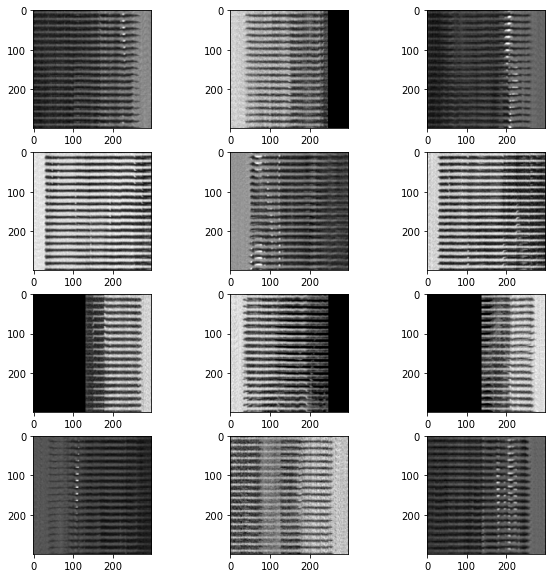

In [30]:
# vykreslenie výstupu augmentácie
x_batch, y_batch = next(train_img_gen)
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 4
for i in range (1, columns*rows +1):
    image = x_batch[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    plt.gray()
plt.show()

### Trénovanie modelu

In [22]:
# konfigurácia procesu trénovania
history = model.fit(train_img_gen,
                    validation_data = (X_valid, y_valid),
                    callbacks = [checkpoint1, callback1],
                    epochs=epochs)

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.6793
Epoch 00001: val_loss improved from inf to 0.66200, saving model to ../FrantisekUrban/callback_model/model2.hdf5
117/117 [==============================] - 61s 522ms/step - loss: 0.7759 - accuracy: 0.6793 - val_loss: 0.6620 - val_accuracy: 0.6800
Epoch 2/20
115/117 [============================>.] - ETA: 0s - loss: 0.5071 - accuracy: 0.7633
Epoch 00002: saving model to ../FrantisekUrban/callback_model/saved-model2-02.h5
117/117 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.7639
Epoch 00002: val_loss did not improve from 0.66200
117/117 [==============================] - 47s 402ms/step - loss: 0.5052 - accuracy: 0.7639 - val_loss: 0.7273 - val_accuracy: 0.6600
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.7834
Epoch 00003: val_loss did not improve from 0.66200
117/117 [==============================] - 41s 351ms/step - los

In [35]:
# vyhodnotenie najlepšieho modelu podľa validačnej chyby
loaded_model = keras.models.load_model('../FrantisekUrban/callback_model/main_with_imggen.hdf5')
print("main_with_imggen.hdf5")
vysledky = loaded_model.evaluate(X_test, y_test)

y_pred = loaded_model.predict(X_test)
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.50] = 1
y_testt = y_test.astype('float32')

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))
rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(rocauc))

main_with_imggen.hdf5
38/38 [==============================] - 3s 87ms/step - loss: 0.5441 - accuracy: 0.7783
Confusion_matrix
[[828 238]
 [ 26  99]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.97      0.78      0.86      1066
    Positive       0.29      0.79      0.43       125

    accuracy                           0.78      1191
   macro avg       0.63      0.78      0.65      1191
weighted avg       0.90      0.78      0.82      1191

AUC: 0.8860412757973734


In [29]:
# plot_history(history)

Text(0, 0.5, 'TPR')

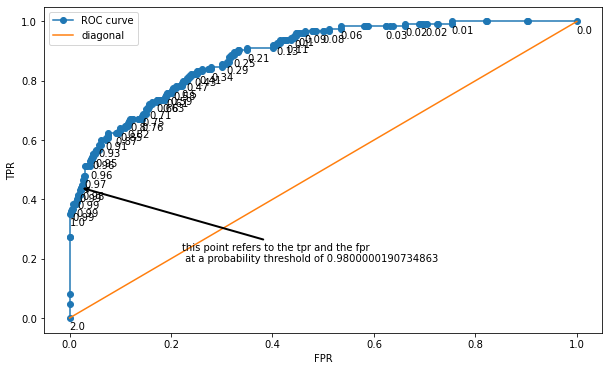

In [36]:
# vykreslenie ROC krivky s optimálnou hodnotou prahu
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 27
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [37]:
loaded_model = keras.models.load_model('../FrantisekUrban/callback_model/main_with_imggen.hdf5')
print("main_with_imggen.hdf5")
vysledky = loaded_model.evaluate(X_test, y_test)

y_pred = loaded_model.predict(X_test)
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.98] = 1
y_testt = y_test.astype('float32')

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))
rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(rocauc))

main_with_imggen.hdf5
38/38 [==============================] - 3s 79ms/step - loss: 0.5441 - accuracy: 0.7783
Confusion_matrix
[[1039   27]
 [  70   55]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.94      0.97      0.96      1066
    Positive       0.67      0.44      0.53       125

    accuracy                           0.92      1191
   macro avg       0.80      0.71      0.74      1191
weighted avg       0.91      0.92      0.91      1191

AUC: 0.8860412757973734


### Vyhodnotenie výsledkov procesu trénovania

In [11]:
drop1 = 0.25 
drop2 = 0.5 
dense = 1024
epochs = 20
batch_size = 40 

def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=[299, 299,1], activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

#     model.summary()
    
    model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [33]:
#načítanie výtvorených váh
weights = glob.glob("../FrantisekUrban/callback_model/" + "*.h5")
weights[65:75]

['../FrantisekUrban/callback_model/main_with_imggen-02.h5',
 '../FrantisekUrban/callback_model/main_with_imggen-04.h5',
 '../FrantisekUrban/callback_model/main_with_imggen-06.h5',
 '../FrantisekUrban/callback_model/main_with_imggen-08.h5',
 '../FrantisekUrban/callback_model/main_with_imggen-10.h5',
 '../FrantisekUrban/callback_model/main_with_imggen-12.h5',
 '../FrantisekUrban/callback_model/main_with_imggen-14.h5',
 '../FrantisekUrban/callback_model/main_with_imggen-16.h5',
 '../FrantisekUrban/callback_model/main_with_imggen-18.h5',
 '../FrantisekUrban/callback_model/main_with_imggen-20.h5']

In [15]:
# vytvorenie dataframu pre uloženie výsledkov
header = ["Model", "Accuracy", "Loss", "AUC"]
dataframe = pd.DataFrame(columns = header)  
dataframe

,Model,Accuracy,Loss,AUC


In [14]:
# vyhodnotenie modelov
for weight in weights[70:75]:
    new_model = create_model()
    new_model.load_weights(weight)
    print(weight.split("/")[3])
    score = new_model.evaluate(X_test, y_test)
    
    y_pred = new_model.predict(X_test)
    y_int = np.zeros_like(y_pred)
    y_int[y_pred > 0.50] = 1
    y_pred_bin = np.where(y_pred > 0.5, 1, 0)
    y_testt = y_test.astype('float32')
    print("DONE")
    
    cm = confusion_matrix(y_testt, y_int)
    print('Confusion_matrix')
    print(cm)
    print('-------------------Classification_report-------------------')
    target_names = ['Negative', 'Positive']
    print(classification_report(y_testt, y_int, target_names=target_names))
    
    rocauc = roc_auc_score(y_test, y_pred)
    print('AUC: {}'.format(rocauc))
    print(" ")
    
    row = {'Model': weight.split("/")[3],
           'Accuracy': round(score[1],4),
           'Loss': round(score[0],4),
           'AUC':round(rocauc,4) ,
          }
    dataframe = dataframe.append(row, ignore_index=True)

main_with_imggen-12.h5
38/38 [==============================] - 3s 75ms/step - loss: 0.2695 - accuracy: 0.8967
DONE
Confusion_matrix
[[978  88]
 [ 35  90]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.97      0.92      0.94      1066
    Positive       0.51      0.72      0.59       125

    accuracy                           0.90      1191
   macro avg       0.74      0.82      0.77      1191
weighted avg       0.92      0.90      0.90      1191

AUC: 0.9129981238273921
 
main_with_imggen-14.h5
38/38 [==============================] - 3s 78ms/step - loss: 0.3119 - accuracy: 0.8648
DONE
Confusion_matrix
[[956 110]
 [ 51  74]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.95      0.90      0.92      1066
    Positive       0.40      0.59      0.48       125

    accuracy                           0.86      11

In [16]:
#zobrazenie dosiahnutých výsledkov
dataframe

,Model,Accuracy,Loss,AUC
0,main_with_imggen-02.h5,0.5903,0.7830,0.7397
1,main_with_imggen-04.h5,0.4568,1.2536,0.7583
2,main_with_imggen-06.h5,0.4173,1.4752,0.8911
3,main_with_imggen-08.h5,0.3887,1.5674,0.8074
4,main_with_imggen-10.h5,0.3879,2.3621,0.8993
5,main_with_imggen-12.h5,0.8967,0.2695,0.9130
6,main_with_imggen-14.h5,0.8648,0.3119,0.8612
7,main_with_imggen-16.h5,0.8438,0.3964,0.8242
8,main_with_imggen-18.h5,0.9328,0.1657,0.9526
9,main_with_imggen-20.h5,0.7573,0.7550,0.9232


In [15]:
#uloženie dataframu
dataframe.to_csv('../FrantisekUrban/experiment2.csv', index=False)

In [19]:
weights[73]

'../FrantisekUrban/callback_model/main_with_imggen-18.h5'

### Vyhodnotenie najlepšieho modelu

In [13]:
# vyhodnotenie na prahu = 0.5
new_model = create_model()
new_model.load_weights(weights[73])
print(weights[73].split("/")[3])
new_model.evaluate(X_test, y_test)

y_pred = new_model.predict(X_test)
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
y_testt = y_test.astype('float32')

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))

rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(rocauc))

main_with_imggen-18.h5
38/38 [==============================] - 3s 85ms/step - loss: 0.1657 - accuracy: 0.9328
Confusion_matrix
[[1015   51]
 [  29   96]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.97      0.95      0.96      1066
    Positive       0.65      0.77      0.71       125

    accuracy                           0.93      1191
   macro avg       0.81      0.86      0.83      1191
weighted avg       0.94      0.93      0.94      1191

AUC: 0.9526378986866791


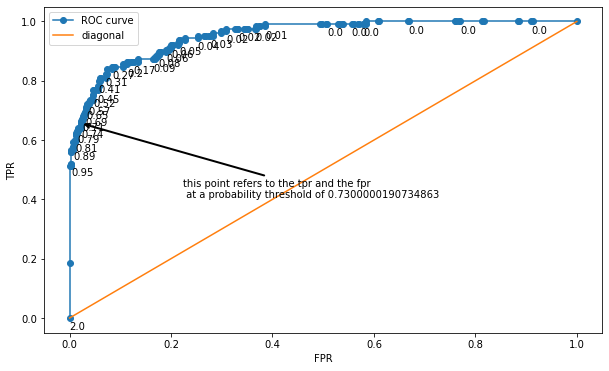

In [17]:
# vykreslenie ROC krivky s optimálnou hodnotou prahu
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 27
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("../FrantisekUrban/plots/e2plot-optROCcurve.png", bbox_inches='tight', dpi = 200)

In [16]:
# vyhodnotenie pri optimálnej hodnote prahu = 0.73
new_model = create_model()
new_model.load_weights(weights[73])
print(weights[73].split("/")[3])
new_model.evaluate(X_test, y_test)

y_pred = new_model.predict(X_test)
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.73] = 1
y_testt = y_test.astype('float32')

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))
rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(rocauc))

main_with_imggen-18.h5
38/38 [==============================] - 3s 77ms/step - loss: 0.1657 - accuracy: 0.9328
Confusion_matrix
[[1042   24]
 [  43   82]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.96      0.98      0.97      1066
    Positive       0.77      0.66      0.71       125

    accuracy                           0.94      1191
   macro avg       0.87      0.82      0.84      1191
weighted avg       0.94      0.94      0.94      1191

AUC: 0.9526378986866791


In [5]:
#načítanie uloženého dataframu vysledkov
dataframe = pd.read_csv('../FrantisekUrban/experiment2.csv')
dataframe

,Model,Accuracy,Loss,AUC
0,main_with_imggen-02.h5,0.5903,0.7830,0.7397
1,main_with_imggen-04.h5,0.4568,1.2536,0.7583
2,main_with_imggen-06.h5,0.4173,1.4752,0.8911
3,main_with_imggen-08.h5,0.3887,1.5674,0.8074
4,main_with_imggen-10.h5,0.3879,2.3621,0.8993
5,main_with_imggen-12.h5,0.8967,0.2695,0.9130
6,main_with_imggen-14.h5,0.8648,0.3119,0.8612
7,main_with_imggen-16.h5,0.8438,0.3964,0.8242
8,main_with_imggen-18.h5,0.9328,0.1657,0.9526
9,main_with_imggen-20.h5,0.7573,0.7550,0.9232


### Grafická reprezentácia výsledkov

In [6]:
# načítanie AUC a Úspešnosti
acc = dataframe["Accuracy"]
auc = dataframe["AUC"]

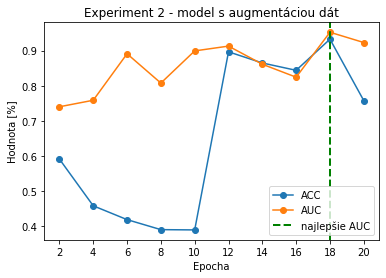

In [7]:
# vykreslenie grafu
epochs = [2,4,6,8,10,12,14,16,18,20]

plt.plot(epochs, acc, label = 'ACC', linestyle='-', marker='o')
plt.plot(epochs, auc, label = 'AUC', linestyle='-', marker='o')

plt.axvline(x = 18, ls='--', lw=2, c='green', label='najlepšie AUC')
# naming the x axis
plt.xlabel('Epocha')
plt.xticks([2,4,6,8,10,12,14,16,18,20])
# naming the y axis
plt.ylabel('Hodnota [%]')
plt.title('Experiment 2 - model s augmentáciou dát')
plt.legend(loc ="lower right")
plt.savefig("../FrantisekUrban/plots/e2plot-vysledok-epoch.png", bbox_inches='tight', dpi = 200)
plt.show()